## 지진관측기록 시각화(Heat map)

In [ ]:
'''
xlsx file to 
'''
import jpype
import asposecells
jpype.startJVM()
from asposecells.api import Workbook, SaveFormat

workbook = Workbook("xlsx_file\\historical_earthquake.xlsx")
workbook.save("csv_file\\historical_earthquake.csv", SaveFormat.CSV)


workbook = Workbook("xlsx_file\\국내지진목록_1978-01-01_2016-10-01.xls")
workbook.save("csv_file\\국내지진목록_1978-01-01_2016-10-01.csv", SaveFormat.CSV)
workbook = Workbook("xlsx_file\\국내지진목록_2016-10-02_2019-12-31.xls")
workbook.save("csv_file\\국내지진목록_2016-10-02_2019-12-31.csv", SaveFormat.CSV)
workbook = Workbook("xlsx_file\\국내지진목록_2020-01-01_2023-06-16.xls")
workbook.save("csv_file\\국내지진목록_2020-01-01_2023-06-16.csv", SaveFormat.CSV)


In [1]:
'''
2 ~ 1904 Earthquake
가중치 : 진도 -> 가속도(PGA)
'''
import pandas as pd
pd.set_option('mode.chained_assignment',  None)

Rom = {'Ⅰ' : 0.035, 'Ⅱ' : 0.15, 'Ⅲ' : 0.495, 'Ⅳ' : 1.66, 'Ⅴ' : 4.71, 'Ⅵ' : 10.795, 'Ⅶ' : 23.195, 'Ⅷ' : 49.835, 'Ⅸ' : 107.075, 'Ⅹ' : 146.14, '-' : 0, '?' : 0}     # 진도 rom num : arabic num

df_his = pd.read_csv("csv_file\\historical_earthquake.csv", encoding='utf-8')
df_his = df_his.rename(columns= df_his.iloc[0])
df_his = df_his.drop(df_his.index[0])
df_his = df_his.drop(df_his.index[len(df_his['진도']) - 1])             # column, 마지막 값(없는 값) 정리

df_his['일자(양력/음력)'] = df_his['일자(양력/음력)'].astype('str')         # 양력만 추출
df_his_date = df_his['일자(양력/음력)'].str.split('/')
df_his['일자'] = df_his_date.str.get(0)

j = 1                                                                 # 진도 arabic num 변환
for i in df_his['진도']:
    if len(i) == 1:
        temp = Rom[i]
        df_his['진도'][j] = temp
    elif len(i) == 3:
        temp = i[2]
        temp = Rom[temp]
        df_his['진도'][j] = temp
    j += 1

df_his['위도/경도'] = df_his['위도/경도'].astype('str')                     # 위도 , 경도 따로 추출, 실수화
df_his = df_his[df_his['위도/경도'] != '진앙미정 / 진앙미정']
df_his_loc = df_his['위도/경도'].str.split('/')
df_his['위도'] = df_his_loc.str.get(0)
df_his['경도'] = df_his_loc.str.get(1)

df_his = df_his.drop(['일자(양력/음력)', '위도/경도', '기사(출전)', '번호', '감진반경(km)'], axis= 'columns')       # column 최종 정리

import folium
from folium import plugins
latitude, longitude = 35.9078, 127.7669                                 # 대한민국의 좌표
S_korea = folium.Map(location = [latitude, longitude], zoom_start = 7)
df_his['위도'] = df_his['위도'].astype('float')
df_his['경도'] = df_his['경도'].astype('float')
df_his['진도'] = df_his['진도'].astype('float')
df_his.to_csv("csv_file\\df_his.csv")
S_korea.add_child(plugins.HeatMap(zip(df_his['위도'], 
                                      df_his['경도'],
                                    df_his['진도']), radius= 15))

   

In [2]:
'''
1904 03 03 ~ 2023 05 25 Earthquake
가중치 : 규모 -> Energy
'''
import pandas as pd
import numpy as np
def RecEqDf(file_name):
    df = pd.read_csv(file_name, encoding= 'utf-8')
    df = df.rename(columns= df.iloc[0])
    df = df.drop(df.index[0:1])
    df['발생시각'].replace('', np.nan, inplace = True)
    df.dropna(subset = ['발생시각'], inplace = True)
    return df
    
dfRec1 = RecEqDf("csv_file\\국내지진목록_1978-01-01_2016-10-01.csv")
dfRec2 = RecEqDf("csv_file\\국내지진목록_2016-10-02_2019-12-31.csv")
dfRec3 = RecEqDf("csv_file\\국내지진목록_2020-01-01_2023-06-16.csv")

df_rec = pd.concat([dfRec1, dfRec2, dfRec3], ignore_index= True)

df_rec.to_csv("csv_file\\Recent_earthquake.csv", encoding="utf-8-sig")

df_rec = df_rec.drop(['번호', '발생시각', '위치', '지도보기', '상세정보\n(진도 등)', '최대\n진도', '깊이(km)'], axis= 'columns')
df_rec['위도'] = df_rec['위도'].astype('str')
rec_lat = df_rec['위도'].str.split(' ')
df_rec['위도'] = rec_lat.str.get(0)

df_rec['경도'] = df_rec['경도'].astype('str')
rec_lat = df_rec['경도'].str.split(' ')
df_rec['경도'] = rec_lat.str.get(0)

j = 0
for i in df_rec['규모']:                        # 규모 -> 에너지 환산 :  https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=gumdansan21&logNo=130135121090
    temp = (11.8 + 1.5 * float(i))
    df_rec.loc[j,'에너지'] = (10 ** temp) * (10 ** -3)
    j += 1
    
df_rec = df_rec[df_rec['위도'] != '-']


import folium                                                            # heatmap 
from folium import plugins
latitude, longitude = 35.9078, 127.7669                                 # 대한민국의 좌표
S_korea = folium.Map(location = [latitude, longitude], zoom_start = 7)

df_rec['위도'] = df_rec['위도'].astype('float')
df_rec['경도'] = df_rec['경도'].astype('float')

S_korea.add_child(plugins.HeatMap(zip(df_rec['위도'],
                                      df_rec['경도'],
                                      df_rec['에너지']), radius= 15))

In [ ]:
df_rec

## 과거 지진 데이터 규모값 있는 html crawling + 최근 지진 데이터 합치기
https://www.seismosoc.org/Publications/BSSA_html/bssa_96-3/05050-esupp/05050-esupp_1.html<br>
값이 들어있는 것은 공통적으로
```html
<td>
```
 형식을 지니고 있음<br>
 <br>
 df_his + df_rec -> new dataframe<br>
 columns : year, month, day, lat, long, ml<br>
<br>
1392 ~ 2023 data

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd

html = urlopen("https://www.seismosoc.org/Publications/BSSA_html/bssa_96-3/05050-esupp/05050-esupp_1.html")
bsObject = BeautifulSoup(html, "html.parser")
data_ml = bsObject.find_all('td', class_ = False)

list_year = []      # 1
list_month = []     # 2
list_day = []       # 3
list_lat = []       # 4
list_long = []      # 5
list_ml = []        # 7

n = 0
for data in data_ml:
    k = n % 10
    if k == 1:
        list_year.append(data.get_text())
    elif k == 2:
        list_month.append(data.get_text())
    elif k == 3:
        list_day.append(data.get_text())
    elif k == 4:
        list_lat.append(data.get_text())
    elif k == 5:
        list_long.append(data.get_text())
    elif k == 7:
        list_ml.append(data.get_text())
    n += 1

raw_data = {'year' : list_year,
            'month' : list_month,
            'day' : list_day,
            'lat' : list_lat,
            'long' : list_long,
            'ml' : list_ml}
dfHisML = pd.DataFrame(raw_data)


def split_data(col):
    df_rec[col] = df_rec[col].astype('str')
    rec = df_rec[col].str.split(' ')
    df_rec[col] = rec.str.get(0)

df_rec = pd.read_csv("csv_file\\Recent_earthquake.csv", encoding= 'utf-8')
df_rec = df_rec.drop(['번호', '위치', '지도보기', '상세정보\n(진도 등)', '최대\n진도', '깊이(km)'], axis= 'columns')

split_data('위도')
split_data('경도')
split_data('발생시각')

temp = df_rec['발생시각'].str.split('/')

list_year = temp.str.get(0).values.tolist()
list_month = temp.str.get(1).values.tolist()
list_day = temp.str.get(2).values.tolist()
list_lat = df_rec['위도'].values.tolist()
list_long = df_rec['경도'].values.tolist()
list_ml = df_rec['규모'].values.tolist()


raw_data = {'year' : list_year,
            'month' : list_month,
            'day' : list_day,
            'lat' : list_lat,
            'long' : list_long,
            'ml' : list_ml,}
dfRecML = pd.DataFrame(raw_data, dtype= object)

dfML = pd.concat([dfHisML, dfRecML], ignore_index= True)

dfML['year'] = dfML['year'].astype('int')



list_ml_erg = []
for i in dfML['ml']:                        # 규모 -> 에너지 환산
    temp = (11.8 + 1.5 * float(i))
    list_ml_erg.append((10 ** temp) * (10 **- 19))              # 단위 : TJ
dfML['ml_erg'] = list_ml_erg

dfML = dfML.drop(dfML[dfML['year'] <= 1392].index)
dfML['lat'] = dfML['lat'].dropna()
dfML['long'] = dfML['long'].dropna()
dfML = dfML.drop(dfML[(dfML['lat'] == '-') | (dfML['long'] == '-')].index)
dfML.to_csv("csv_file\\earthquake_ML.csv")

## 좌표에 따른 시군구 위치 산출(ver 1)

In [5]:
import pandas as pd
import json
import geopandas as gpd
from fiona.crs import from_epsg
sigungu_geojson = 'json_file/SIGUNGU_2302.json'
dfML = pd.read_csv("csv_file\\earthquake_ML.csv")
dfML = dfML.drop(['Unnamed: 0'], axis= 'columns')

with open(sigungu_geojson,'r',encoding="utf-8") as f:
    json_data = json.load(f)

gdf_pt_geom = gpd.points_from_xy(dfML.long, dfML.lat)
eq_gpd = gpd.GeoDataFrame(dfML, geometry=gdf_pt_geom, crs=from_epsg(4326))              # dfML 좌표


sigungu_gdf = gpd.read_file(sigungu_geojson)
sigungu_gdf = gpd.GeoDataFrame(sigungu_gdf, geometry=sigungu_gdf['geometry'], crs=from_epsg(4326))          # 시군구 geodataframe

place_data = gpd.sjoin(eq_gpd, sigungu_gdf, how = "inner")
for i in range(len(sigungu_gdf)): #시군구별 평균 구하기
    ml_erg = place_data[sigungu_gdf['SIG_CD'][i] == place_data['SIG_CD']]['ml_erg'].sum() / 1000
    ml_max = place_data[sigungu_gdf['SIG_CD'][i] == place_data['SIG_CD']]['ml'].max()

    sigungu_gdf.loc[i,"ml_erg"] = ml_erg
    sigungu_gdf.loc[i,"ml_max_old"] = ml_max


In [100]:
sigungu_gdf.query("CTP_KOR_NM == '서울특별시'")

#자신 시군구 내에 위치한 지진만 포함시키다 보니,
#바로 옆 중랑구에서 5.8의 지진 기록이 있었어도, 노원구에는 지진 위험이 없다고 표시되는 문제

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,CTP_KOR_NM,geometry,ml_erg,ml_max_old
0,11110,Jongno-gu,종로구,서울특별시,"POLYGON ((127.01179 37.58157, 127.00864 37.580...",3.548134e-10,0.5
1,11140,Jung-gu,중구,서울특별시,"POLYGON ((127.02337 37.57191, 127.01708 37.569...",5.011872e-10,0.6
2,11170,Yongsan-gu,용산구,서울특별시,"POLYGON ((127.00899 37.54413, 127.00502 37.546...",0.000000e+00,NaN
3,11200,Seongdong-gu,성동구,서울특별시,"POLYGON ((127.07238 37.55996, 127.07086 37.560...",0.000000e+00,NaN
4,11215,Gwangjin-gu,광진구,서울특별시,"POLYGON ((127.11525 37.55676, 127.11230 37.559...",0.000000e+00,NaN
5,11230,Dongdaemun-gu,동대문구,서울특별시,"POLYGON ((127.07108 37.60732, 127.07108 37.607...",0.000000e+00,NaN
6,11260,Jungnang-gu,중랑구,서울특별시,"POLYGON ((127.10089 37.57376, 127.10344 37.580...",6.726029e-02,5.8
7,11290,Seongbuk-gu,성북구,서울특별시,"POLYGON ((127.00707 37.58409, 127.00864 37.580...",7.753030e-01,6.7
8,11305,Gangbuk-gu,강북구,서울특별시,"POLYGON ((127.00457 37.68508, 126.99731 37.683...",0.000000e+00,NaN
9,11320,Dobong-gu,도봉구,서울특별시,"POLYGON ((127.00866 37.68445, 127.00942 37.679...",0.000000e+00,NaN


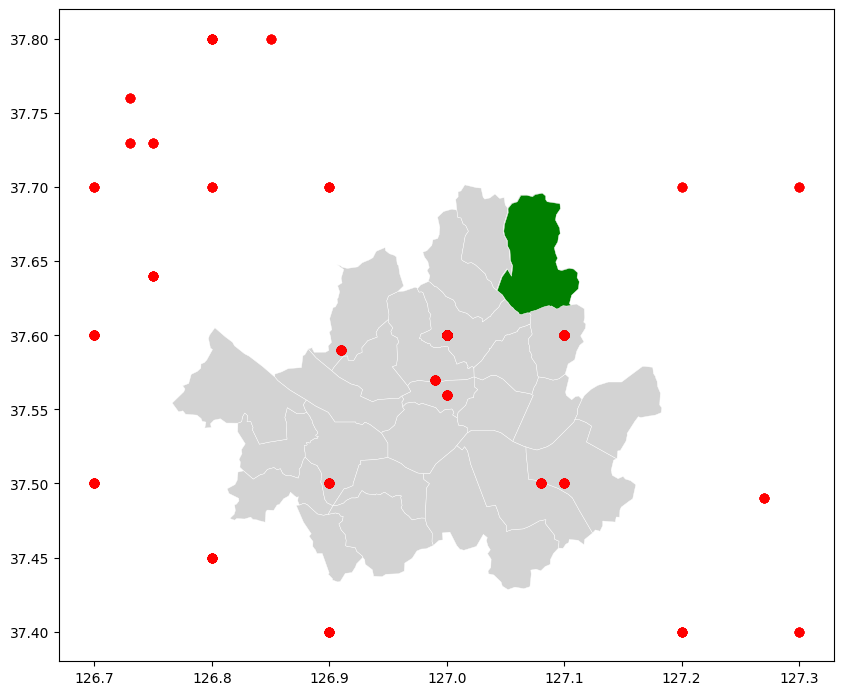

In [107]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sigungu_gdf.query("CTP_KOR_NM == '서울특별시'").plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.3)
sigungu_gdf.query("SIG_KOR_NM == '노원구'").plot(ax=ax, color='green', edgecolor='white', linewidth=0.3)

eq_buffer_data.query("geometry.x >= 126.7 & geometry.x <= 127.3 & geometry.y >= 37.4 & geometry.y <= 37.8").plot(ax=ax, color='red', figsize=5)

plt.show()

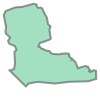

In [8]:
sigungu_gdf["geometry"][0]

C:\Users\padagi\AppData\Local\Temp\ipykernel_31860\2676130804.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd.GeoSeries(sigungu_gdf.buffer(0.01))[0]


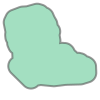

In [36]:
gpd.GeoSeries(sigungu_gdf.buffer(0.01))[0]

In [7]:
sigungu_buffer_gdf = sigungu_gdf.copy()

In [8]:
for i in range(len(sigungu_gdf)):
    sigungu_buffer_gdf.loc[i,"geometry"] = sigungu_gdf.loc[i,"geometry"].buffer(0.1)

In [103]:
sigungu_buffer_gdf

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,CTP_KOR_NM,geometry,ml_erg,ml_max_old
0,11110,Jongno-gu,종로구,서울특별시,"POLYGON ((126.85070 37.60455, 126.84945 37.612...",3.548134e-10,0.5
1,11140,Jung-gu,중구,서울특별시,"POLYGON ((126.86192 37.55289, 126.86181 37.554...",5.011872e-10,0.6
2,11170,Yongsan-gu,용산구,서울특별시,"POLYGON ((126.85262 37.49476, 126.85142 37.497...",0.000000e+00,NaN
3,11200,Seongdong-gu,성동구,서울특별시,"POLYGON ((126.93058 37.60901, 126.93423 37.617...",0.000000e+00,NaN
4,11215,Gwangjin-gu,광진구,서울특별시,"POLYGON ((126.97855 37.59423, 126.97947 37.596...",0.000000e+00,NaN
...,...,...,...,...,...,...,...
245,48870,Hamyang-gun,함양군,경상남도,"POLYGON ((127.49298 35.59309, 127.49483 35.599...",8.645595e-04,4.7
246,48880,Geochang-gun,거창군,경상남도,"POLYGON ((127.59923 35.82918, 127.60159 35.833...",4.849559e-03,5.2
247,48890,Hapcheon-gun,합천군,경상남도,"POLYGON ((127.85369 35.52551, 127.85340 35.528...",1.006308e+00,6.4
248,50110,Jeju-si,제주시,제주특별자치도,"MULTIPOLYGON (((126.06331 33.33282, 126.06322 ...",3.162426e-02,5.8


In [9]:
eq_buffer_data = gpd.sjoin(eq_gpd, sigungu_buffer_gdf, how = "inner")

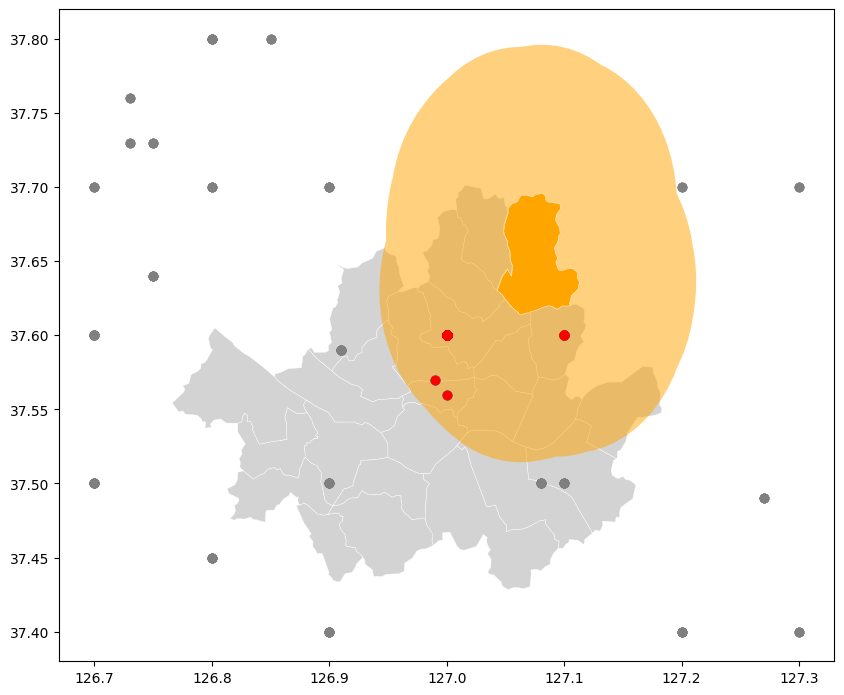

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sigungu_gdf.query("CTP_KOR_NM == '서울특별시'").plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.3)
sigungu_buffer_gdf.query("SIG_KOR_NM == '노원구'").plot(ax=ax, color='orange',alpha=0.5)
sigungu_gdf.query("SIG_KOR_NM == '노원구'").plot(ax=ax, color='orange', edgecolor='white', linewidth=0.3)

eq_buffer_data.query("geometry.x >= 126.7 & geometry.x <= 127.3 & geometry.y >= 37.4 & geometry.y <= 37.8").plot(ax=ax, color='grey', figsize=5)
eq_buffer_data.query("SIG_KOR_NM == '노원구'").plot(ax=ax, color='red', figsize=5)

plt.show()

In [112]:
eq_buffer_data

,year,month,day,lat,long,ml,ml_erg_left,geometry,index_right,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,CTP_KOR_NM,ml_erg_right,ml_max_old
0,1393,3,20,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),21,11650,Seocho-gu,서초구,서울특별시,0.000000e+00,NaN
1,1395,1,3,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),21,11650,Seocho-gu,서초구,서울특별시,0.000000e+00,NaN
2,1397,4,2,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),21,11650,Seocho-gu,서초구,서울특별시,0.000000e+00,NaN
3,1397,12,10,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),21,11650,Seocho-gu,서초구,서울특별시,0.000000e+00,NaN
4,1398,3,22,37.60,127.00,3.5,0.011220,POINT (127.00000 37.60000),21,11650,Seocho-gu,서초구,서울특별시,0.000000e+00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9833,2023,05,19,34.43,125.99,1.6,0.000016,POINT (125.99000 34.43000),200,46900,Jindo-gun,진도군,전라남도,1.806463e-07,2.3
9834,2023,05,19,34.43,125.99,1.5,0.000011,POINT (125.99000 34.43000),200,46900,Jindo-gun,진도군,전라남도,1.806463e-07,2.3
10799,2022,04,06,34.66,126.20,1.6,0.000016,POINT (126.20000 34.66000),200,46900,Jindo-gun,진도군,전라남도,1.806463e-07,2.3
11997,2020,09,02,34.38,126.20,2.3,0.000178,POINT (126.20000 34.38000),200,46900,Jindo-gun,진도군,전라남도,1.806463e-07,2.3


In [11]:
for i in range(len(sigungu_gdf)): #시군구별 평균 구하기
    ml_max = eq_buffer_data[sigungu_gdf['SIG_CD'][i] == eq_buffer_data['SIG_CD']]['ml'].max()

    sigungu_gdf.loc[i,"ml_max_new"] = ml_max

In [33]:
sigungu_gdf_sort = sigungu_gdf.sort_values('ml_max_new',ascending=False)

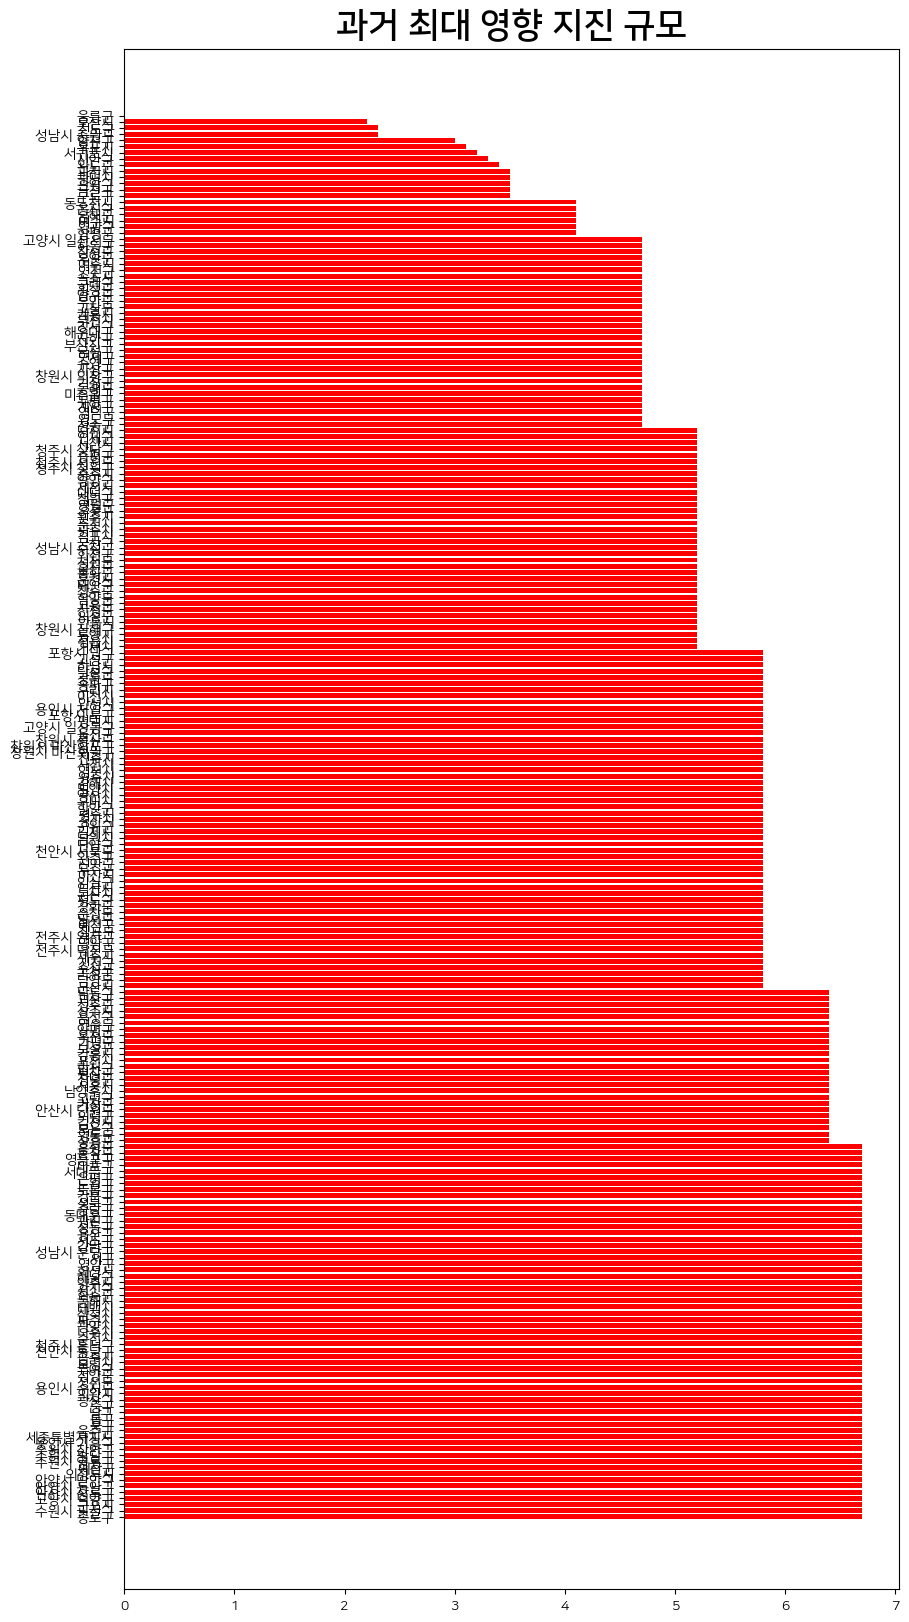

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 20))

ax.barh(sigungu_gdf_sort["SIG_KOR_NM"],sigungu_gdf_sort["ml_max_new"], color="red")

plt.title("과거 최대 영향 지진 규모", fontdict = {'fontsize' : 25, 'fontweight':"bold"}, pad=10)
plt.show()
fig.savefig("mt_max_bar.png", dpi = 500)

In [115]:
sigungu_gdf.query("CTP_KOR_NM == '서울특별시'")

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,CTP_KOR_NM,geometry,ml_erg,ml_max_old,ml_max_new
0,11110,Jongno-gu,종로구,서울특별시,"POLYGON ((127.01179 37.58157, 127.00864 37.580...",3.548134e-10,0.5,6.7
1,11140,Jung-gu,중구,서울특별시,"POLYGON ((127.02337 37.57191, 127.01708 37.569...",5.011872e-10,0.6,6.7
2,11170,Yongsan-gu,용산구,서울특별시,"POLYGON ((127.00899 37.54413, 127.00502 37.546...",0.000000e+00,NaN,6.7
3,11200,Seongdong-gu,성동구,서울특별시,"POLYGON ((127.07238 37.55996, 127.07086 37.560...",0.000000e+00,NaN,6.7
4,11215,Gwangjin-gu,광진구,서울특별시,"POLYGON ((127.11525 37.55676, 127.11230 37.559...",0.000000e+00,NaN,6.7
5,11230,Dongdaemun-gu,동대문구,서울특별시,"POLYGON ((127.07108 37.60732, 127.07108 37.607...",0.000000e+00,NaN,6.7
6,11260,Jungnang-gu,중랑구,서울특별시,"POLYGON ((127.10089 37.57376, 127.10344 37.580...",6.726029e-02,5.8,6.7
7,11290,Seongbuk-gu,성북구,서울특별시,"POLYGON ((127.00707 37.58409, 127.00864 37.580...",7.753030e-01,6.7,6.7
8,11305,Gangbuk-gu,강북구,서울특별시,"POLYGON ((127.00457 37.68508, 126.99731 37.683...",0.000000e+00,NaN,6.7
9,11320,Dobong-gu,도봉구,서울특별시,"POLYGON ((127.00866 37.68445, 127.00942 37.679...",0.000000e+00,NaN,6.7


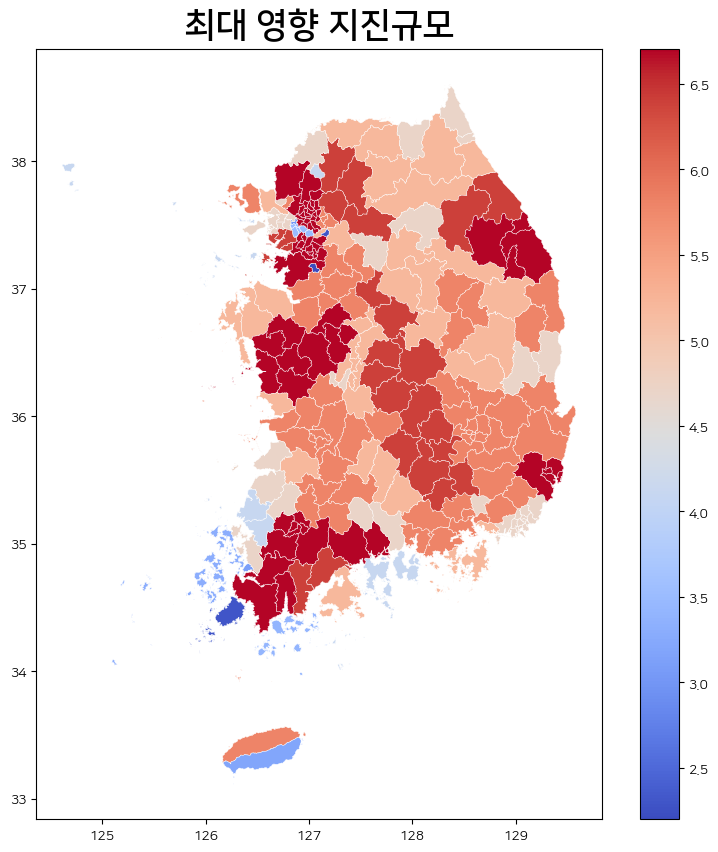

In [13]:
plt.rcParams['font.family'] = "NanumSquare"
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sigungu_gdf.plot(column='ml_max_new',cmap='coolwarm', ax=ax, edgecolor='white', linewidth=0.3, legend=True)

#eq_gpd.plot(ax=ax, color='black')
#test.plot(ax=ax, color='green')
#place_data.plot(ax=ax, color='red')

plt.title("최대 영향 지진규모", fontdict = {'fontsize' : 25, 'fontweight':"bold"}, pad=10)

plt.show()

fig.savefig("mt_max.png", dpi = 500)

In [127]:
import pickle
with open('merge_gdf/sigungu_gdf_eq.pickle', 'wb') as f:
        pickle.dump(sigungu_gdf, f)